# AMADEUS CHALLENGE

### Introduction

The following challenge is conducted as part of the Kschool Master in Data Science. 

The challenge was created by Amadeus to asses the Data Science skills of candidates, and it consist in resolving three + two exercises given two files about flight bookings and searches. The exercises are:

- **First exercise:** count the number of lines of each file in Python
- **Second exercise:** identify the top 10 arrival airports in 2013
- **Third exercise:** plot the monthly number of searches or flights arriving at Madrid, Barcelona and Malaga
- **Bonus 1:** match searches with bookings and export results in a CSV file
- **Bonus 2:** write a web service


In [12]:
#Get name of files and size
!ls -l --block-size=M ../

total 8041M
drwxrwxr-x 4 dsc dsc    1M may 29 12:54 amadeus_challenge
-rw-rw-r-- 1 dsc dsc 4049M abr  2  2018 bookings.csv
-rw-rw-r-- 1 dsc dsc  405M may 29 12:52 bookings_no_duplicates.csv
-rw-rw-r-- 1 dsc dsc 3525M abr  2  2018 searches.csv
-rw-rw-r-- 1 dsc dsc   63M may 29 12:46 searches_no_duplicates.csv


In [15]:
!cat ../bookings.csv | wc

10000011 279827136 4244874509


In [17]:
!cat ../searches.csv | wc

20390198 20496592 3696229366


The size of the files is too big to load it at once in memory, hence the files will need to be loaded as iterators.

In [18]:
#import libraries used
import pandas as pd
import io
import requests
import matplotlib.pyplot as plt
import hashlib

#Plot inside jupyter
%matplotlib inline

#Show all columns printing pandas objects
pd.options.display.max_columns = None


## Exercise 1: Count the number of lines in Python for each line

In [19]:
#Read files as iterator (due to memory constraints) with only one column to reduce the size of the file
bookings_reader=pd.read_csv("../bookings.csv", delimiter="^", iterator=True, chunksize = 10000, usecols=[0])
searches_reader=pd.read_csv("../searches.csv", delimiter="^", iterator=True, chunksize = 10000, usecols=[0])

In [21]:
#Function to calculate the length dataframe given its iterator
def file_lines (file):
    """Returns the length of a given file that has been read with the itereator"""
    length = 0
    for b_chunk in file:
        length += b_chunk.shape[0] #Adding the rows of each segment
    return length

In [ ]:
bookings_len = file_lines(bookings_reader)
searches_len = file_lines(searches_reader)

In [38]:
print("Total lines of 'bookings.csv': {:,}".format(bookings_len))
print("Total lines of 'searches.csv': {:,}".format(searches_len))

Total lines of 'bookings.csv': 10,000,010
Total lines of 'searches.csv': 20,390,198


The total number of lines is:

- bookings.csv:  10000010 lines + header
- searches.csv: 20390198 lines + header


    

## Identifying and Cleaning Duplicates (if found)

To identify if there are duplicates, if we could load all the data into one DF we could call the methodn. duplicated() and check if there is any True value, however since we have to load the data into df chunks, it is possible that there are no duplicates within a chunk, but there are whithin different chunks.

For this reason, and since finding one duplicate means that there duplicates, we will follow this strategy to identify duplicates:

- First, we will check for duplicates using bash
- Then, we will check on Python. In python we will first check if we find duplicates within the first 20 chunks. If we find duplicates within the 20 first chunks, we will proceed remove them.

#### Checking duplicates in bash

In [ ]:
#Duplicated lines (searches.csv)
!sort -t "^" ../searches.csv| uniq -d | wc -l

In [ ]:
#Unique lines (searches.csv)
!sort -u -t "^" ../searches.csv | wc -l

In [ ]:
#total lines (searches.csv)
!sort -t "^" ../searches.csv| wc -l

In [ ]:
#Duplicated lines (bookings.csv)
!sort -t "^" ../bookings.csv| uniq -d | wc -l

In [ ]:
#Unique lines (bookings.csv)
!sort -u -t "^" ../bookings.csv | wc -l

In [ ]:
#total lines (bookings.csv)
!sort -t "^" ../bookings.csv| wc -l

#### Now in Python

In [23]:
#Reading files with iterator
searches_reader=pd.read_csv("../searches.csv", 
                            delimiter="^", 
                            iterator=True, 
                            chunksize = 10000)
bookings_reader=pd.read_csv("../bookings.csv", 
                            delimiter="^", 
                            iterator=True, 
                            chunksize = 10000)

In [24]:
#Reading the first chunk of each file
s_duplicate = False
b_duplicate = False
for i in range(0,20):
    s_chunk = searches_reader.get_chunk()
    b_chunk = bookings_reader.get_chunk()

    if True in s_chunk.duplicated().values:
        s_duplicate = True
    if True in b_chunk.duplicated().values:
        b_duplicate = True
        
print("Searches duplicates: {}".format(s_duplicate))
print("Bookings duplicates: {}".format(b_duplicate))

Searches duplicates: True
Bookings duplicates: False


Searching for duplicates within the chunks have resulted in identifying that searches.csv contains duplicates, and bookings.csv does not. However, as we explained before scoring True in this test proves that there are duplicates, but scoring False does not prove the opposite, is for this reason that both files will be treated for duplicates.

The method that we will be following is creating a hash table for each line in the files, and then iterating over the file, and creating a new file with only one occurrence of each hash as indicated by Stackoverlow user "zwer" in the following thread: https://stackoverflow.com/questions/52407474/removing-duplicates-on-very-large-datasets

In [25]:
def remove_duplicates (input_file,output_file):
    with open(input_file, "r") as f_in, \
            open(output_file, "w") as f_out:
        seen = set()  # a set to hold our 'visited' lines
        for line in f_in:  # iterate over the input file line by line
            line_hash = hashlib.md5(line.encode()).digest()  # hash the value
            if line_hash not in seen:  # we're seeing this line for the first time
                seen.add(line_hash)  # add it to the hash table
                f_out.write(line)  # write the line to the output

In [26]:
remove_duplicates("../searches.csv","../searches_no_duplicates.csv")

In [27]:
remove_duplicates("../bookings.csv","../bookings_no_duplicates.csv")

In [28]:
searches_lines_n_dup=file_lines(pd.read_csv("../searches_no_duplicates.csv", 
                            delimiter="^", 
                            iterator=True, 
                            chunksize = 10000))

In [29]:
bookings_lines_n_dup=file_lines(pd.read_csv("../bookings_no_duplicates.csv", 
                            delimiter="^", 
                            iterator=True, 
                            chunksize = 10000))

In [49]:
print("BOOKINGS.CSV \n------------")
print("Duplicated lines: {:10,}".format(bookings_len - bookings_lines_n_dup))
print("Total lines     : {:10,}".format(bookings_lines_n_dup))


print("\n\nSEARCHES.CSV \n------------")
print("Duplicated lines: {:10,}".format(searches_len - searches_lines_n_dup))
print("Total lines     : {:10,}".format(searches_lines_n_dup))


BOOKINGS.CSV 
------------
Duplicated lines:  9,000,007
Total lines     :  1,000,003


SEARCHES.CSV 
------------
Duplicated lines: 20,031,194
Total lines     :    359,004


It has been found file bookings.csv cointained 9 million duplicates, and 20 million duplicates in searches.csv.

The total number of lines 
- bookings.csv: 9,000,007
- searches.csv: 359,004

## Exercise 2: Top 10 arrivals  [no duplicates]

In [64]:
#Read file including only "arr_port" and "pax" to calculate top 10 airports
chunks_booking=pd.read_csv("../bookings_no_duplicates.csv", usecols=["arr_port","pax"],delimiter="^", iterator=True, chunksize = 10000 )#names=[arr_port,pax]

In [65]:
#Read all the chuncks and group by arrival airport aggregating by bookings passangers ("pax")
pieces_bookings = [x.groupby('arr_port').sum() for x in chunks_booking]

In [66]:
#Concatenate all the pieces
agg_bookings = pd.concat(pieces).groupby(level=0).sum()

In [67]:
#Reset index, strip the names, and assign back the index
agg_bookings.reset_index(inplace=True)
agg_bookings["arr_port"]=agg_bookings["arr_port"].str.strip()
agg_bookings.set_index("arr_port", inplace=True)
#print top 10 airports per number of passangers
agg_bookings.iloc[:,0].sort_values(ascending=False).head(10)

arr_port
LHR    8881.0
MCO    7093.0
LAX    7053.0
LAS    6963.0
JFK    6627.0
CDG    6449.0
BKK    5946.0
MIA    5815.0
SFO    5800.0
DXB    5559.0
Name: pax, dtype: float64

In [68]:
#Importing airport names from GeoBases selecting only columns iata_code, airport name and country name
url="https://raw.githubusercontent.com/opentraveldata/geobases/public/GeoBases/DataSources/Airports/GeoNames/airports_geonames_only_clean.csv"
columns=["iata_code","airport_name","country_name"]
iata_names = pd.read_csv(url, delimiter ="^",usecols=[0,1,4],header=None, names=columns)

#strip iata_codes and set as index
iata_names["iata_code"]=iata_names["iata_code"].str.strip()
iata_names.set_index("iata_code", inplace=True)

In [69]:
#merge files on idex to include names of country and airprt
agg_bookings_iata_names=agg_bookings.join(iata_names, how="left")

#print top 10 airports per number of passangers including airport name and country
agg_bookings_iata_names.sort_values(by="pax",ascending=False).head(10)

,pax,airport_name,country_name
arr_port,,,
LHR,8881.0,London Heathrow Airport,United Kingdom
MCO,7093.0,Orlando International Airport,United States
LAX,7053.0,Los Angeles International Airport,United States
LAS,6963.0,McCarran International Airport,United States
JFK,6627.0,John F Kennedy International Airport,United States
CDG,6449.0,Paris - Charles-de-Gaulle,France
BKK,5946.0,Suvarnabhumi,Thailand
MIA,5815.0,Miami International Airport,United States
SFO,5800.0,San Francisco International Airport,United States


## THIRD EXERCISE: plot the monthly number of searches for flights arriving at Malaga, Madrid or Barcelona. [no duplicates]

Plot one curve for Malaga, another for Madrid and another for Barcelona in the same fig.

In [75]:
#Explore searches file to select only relevant columns
searches_reader=pd.read_csv("../searches_no_duplicates.csv", delimiter="^", iterator=True, chunksize = 10000)
searches_df=searches_reader.get_chunk()

In [76]:
searches_df.head()

,Date,Time,TxnCode,OfficeID,Country,Origin,Destination,RoundTrip,NbSegments,Seg1Departure,Seg1Arrival,Seg1Date,Seg1Carrier,Seg1BookingCode,Seg2Departure,Seg2Arrival,Seg2Date,Seg2Carrier,Seg2BookingCode,Seg3Departure,Seg3Arrival,Seg3Date,Seg3Carrier,Seg3BookingCode,Seg4Departure,Seg4Arrival,Seg4Date,Seg4Carrier,Seg4BookingCode,Seg5Departure,Seg5Arrival,Seg5Date,Seg5Carrier,Seg5BookingCode,Seg6Departure,Seg6Arrival,Seg6Date,Seg6Carrier,Seg6BookingCode,From,IsPublishedForNeg,IsFromInternet,IsFromVista,TerminalID,InternetOffice
0,2013-01-01,20:25:57,MPT,624d8c3ac0b3a7ca03e3c167e0f48327,DE,TXL,AUH,1,2,TXL,AUH,2013-01-26,D2,NaN,AUH,TXL,2013-02-02,D2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,FRA
1,2013-01-01,10:15:33,MPT,b0af35b31588dc4ab06d5cf2986e8e02,MD,ATH,MIL,0,1,ATH,MIL,2013-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,KIV
2,2013-01-01,18:04:49,MPT,3561a60621de06ab1badc8ca55699ef3,US,ICT,SFO,1,2,ICT,SFO,2013-08-02,NaN,NaN,SFO,ICT,2013-08-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,NYC
3,2013-01-01,17:42:40,FXP,1864e5e8013d9414150e91d26b6a558b,SE,RNB,ARN,0,1,RNB,ARN,2013-01-02,DU,W,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASI,0,0,0,d41d8cd98f00b204e9800998ecf8427e,STO
4,2013-01-01,17:48:29,MPT,1ec336348f44207d2e0027dc3a68c118,NO,OSL,MAD,1,2,OSL,MAD,2013-03-22,NaN,NaN,MAD,OSL,2013-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,OSL


In [77]:
#Select Relevant columns
relevant_columns=["Date","Destination"]

#Function to parse dates and times 
dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d')

#Import only relevant columns, merging dates and parsing it to datetime
searches_reader=pd.read_csv("../searches.csv", 
                            delimiter="^", 
                            iterator=True, 
                            chunksize = 10000, 
                            usecols=relevant_columns,
                            parse_dates={'datetime': ['Date']},
                            date_parser=dateparse)

#Read first chunk
searches_chunk=searches_reader.get_chunk()

#Explore the type of the columns
searches_chunk.info()
searches_chunk.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
datetime       10000 non-null datetime64[ns]
Destination    10000 non-null object
dtypes: datetime64[ns](1), object(1)
memory usage: 156.3+ KB


,datetime,Destination
0,2013-01-01,AUH
1,2013-01-01,MIL
2,2013-01-01,SFO
3,2013-01-01,ARN
4,2013-01-01,MAD


In [78]:
searches_reader=pd.read_csv("../searches_no_duplicates.csv", 
                            delimiter="^", 
                            iterator=True, 
                            chunksize = 10000, 
                            usecols=relevant_columns)

In [79]:
#Filtering Madrid (MAD), Barcelona(BCN) & Malaga(AGP)
pieces = []

for chunk in searches_reader:
    #Clean destination file
    chunk["Destination"] = chunk["Destination"].str.strip()
    query= (chunk["Destination"]=="MAD") | (chunk["Destination"]=="BCN") | (chunk["Destination"]=="AGP")
    pieces.append(chunk[query])

#Concat all pieces
searches_esp = pd.concat(pieces)

#Convert dates to datetime
searches_esp["Date"] = pd.to_datetime(searches_esp["Date"])

In [80]:
to_plot = searches_esp[searches_esp["Destination"]=="MAD"].resample("M", on="Date").count()
to_plot["Date"]

Date
2013-01-31    425
2013-02-28    400
2013-03-31    433
2013-04-30    443
2013-05-31    462
2013-06-30    400
2013-07-31    403
2013-08-31    383
2013-09-30    371
2013-10-31    395
2013-11-30    362
2013-12-31    259
Freq: M, Name: Date, dtype: int64

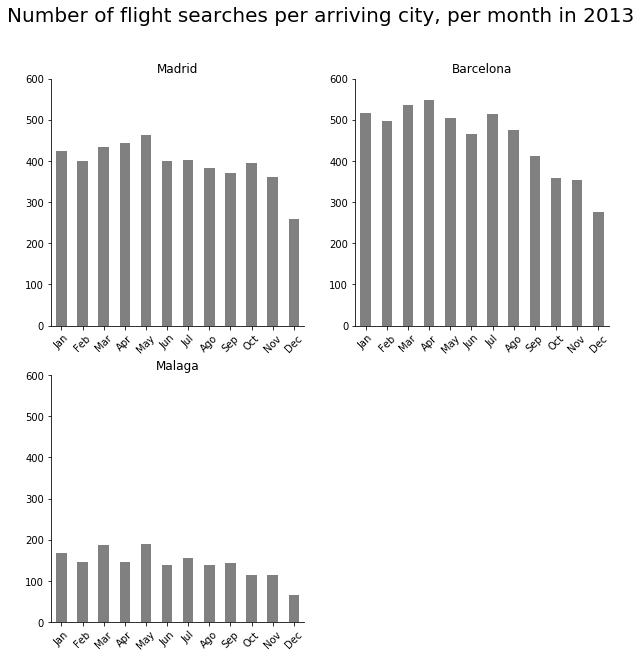

In [86]:
airports = {"MAD":"Madrid","BCN":"Barcelona","AGP":"Malaga"}
months = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Ago","Sep","Oct","Nov","Dec"]

#Create figure
fig = plt.figure(figsize=(10, 10))
fig.suptitle('Number of flight searches per arriving city, per month in 2013', fontsize=20)

#Aggregate and plot
for i,air in enumerate(airports):
    ax = fig.add_subplot(2,2,i+1)
    to_plot = searches_esp[searches_esp["Destination"]==air].resample("M", on="Date").count()
    to_plot["Date"].plot(kind="bar",ax=ax, title=airports[air], rot=45, color="grey", legend=None)
    ax.set_xticklabels(months)
    ax.xaxis.set_label_text("")
    ax.set_ylim(0,600)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

## BONUS EXERCISE: match searches with bookings [no duplicates]

For every search in the searches file, find out whether ended up in a booking or not.
Generate a csv with the searches with an additional column containing 1 if the search ended up in a booking or 0 in any other case.

origin and destination in the search should match with the booking

Process:
1. Identify columns to compare in both files.
2. Add a column with "1"s to bookings df
3. Left join bookings into searches by the columns identifiedin step 1
4. Assign 0 to "NaN"s on the new column 

In [130]:
bookings_relevant_col
searches_relevant_cols

NameError: name 'bookings_relevant_col' is not defined

,Date,Time,TxnCode,OfficeID,Country,Origin,Destination,RoundTrip,NbSegments,Seg1Departure,Seg1Arrival,Seg1Date,Seg1Carrier,Seg1BookingCode,Seg2Departure,Seg2Arrival,Seg2Date,Seg2Carrier,Seg2BookingCode,Seg3Departure,Seg3Arrival,Seg3Date,Seg3Carrier,Seg3BookingCode,Seg4Departure,Seg4Arrival,Seg4Date,Seg4Carrier,Seg4BookingCode,Seg5Departure,Seg5Arrival,Seg5Date,Seg5Carrier,Seg5BookingCode,Seg6Departure,Seg6Arrival,Seg6Date,Seg6Carrier,Seg6BookingCode,From,IsPublishedForNeg,IsFromInternet,IsFromVista,TerminalID,InternetOffice
0,2013-01-01,20:25:57,MPT,624d8c3ac0b3a7ca03e3c167e0f48327,DE,TXL,AUH,1,2,TXL,AUH,2013-01-26,D2,NaN,AUH,TXL,2013-02-02,D2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,FRA
1,2013-01-01,10:15:33,MPT,b0af35b31588dc4ab06d5cf2986e8e02,MD,ATH,MIL,0,1,ATH,MIL,2013-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,KIV
2,2013-01-01,18:04:49,MPT,3561a60621de06ab1badc8ca55699ef3,US,ICT,SFO,1,2,ICT,SFO,2013-08-02,NaN,NaN,SFO,ICT,2013-08-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,NYC
3,2013-01-01,17:42:40,FXP,1864e5e8013d9414150e91d26b6a558b,SE,RNB,ARN,0,1,RNB,ARN,2013-01-02,DU,W,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASI,0,0,0,d41d8cd98f00b204e9800998ecf8427e,STO
4,2013-01-01,17:48:29,MPT,1ec336348f44207d2e0027dc3a68c118,NO,OSL,MAD,1,2,OSL,MAD,2013-03-22,NaN,NaN,MAD,OSL,2013-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,OSL


Looking at the data, it seems that one search can lead to multiple booking lines. However, for the purpose of the exercise we will assume that only one 

## Exercise 2: Top 10 arrivals [duplicates] 

In [7]:
#Read file including only "arr_port" and "pax" to calculate top 10 airports
chunks_booking=pd.read_csv("../bookings.csv", usecols=["arr_port","pax"],delimiter="^", iterator=True, chunksize = 10000 )#names=[arr_port,pax]

In [8]:
#Read all the chuncks aggregate data by airport ("arr_port") adding the bookings passangers ("pax")
pieces = [x.groupby('arr_port').sum() for x in chunks_booking]

In [9]:
#Concatenate all the pieces
agg = pd.concat(pieces).groupby(level=0).sum()

In [10]:
#Reset index, strip the names, and assign back the index
agg.reset_index(inplace=True)
agg["arr_port"]=agg["arr_port"].str.strip()
agg.set_index("arr_port", inplace=True)
#print top 10 airports per number of passangers
agg.iloc[:,0].sort_values(ascending=False).head(10)

arr_port
LHR    88809.0
MCO    70930.0
LAX    70530.0
LAS    69630.0
JFK    66270.0
CDG    64490.0
BKK    59460.0
MIA    58150.0
SFO    58000.0
DXB    55590.0
Name: pax, dtype: float64

In [11]:
#Importing airport names from GeoBases selecting only columns iata_code, airport name and country name
url="https://raw.githubusercontent.com/opentraveldata/geobases/public/GeoBases/DataSources/Airports/GeoNames/airports_geonames_only_clean.csv"
columns=["iata_code","airport_name","country_name"]
iata_names = pd.read_csv(url, delimiter ="^",usecols=[0,1,4],header=None, names=columns)

#strip iata_codes and set as index
iata_names["iata_code"]=iata_names["iata_code"].str.strip()
iata_names.set_index("iata_code", inplace=True)

In [12]:
#merge files on idex to include names of country and airprt
aux=agg.join(iata_names, how="left")

#print top 10 airports per number of passangers including airport name and country
aux.sort_values(by="pax",ascending=False).head(10)

,pax,airport_name,country_name
arr_port,,,
LHR,88809.0,London Heathrow Airport,United Kingdom
MCO,70930.0,Orlando International Airport,United States
LAX,70530.0,Los Angeles International Airport,United States
LAS,69630.0,McCarran International Airport,United States
JFK,66270.0,John F Kennedy International Airport,United States
CDG,64490.0,Paris - Charles-de-Gaulle,France
BKK,59460.0,Suvarnabhumi,Thailand
MIA,58150.0,Miami International Airport,United States
SFO,58000.0,San Francisco International Airport,United States


## THIRD EXERCISE: plot the monthly number of searches for flights arriving at Malaga, Madrid or Barcelona. [duplicates]

Plot one curve for Malaga, another for Madrid and another for Barcelona in the same fig.

In [13]:
#Explore searches file to select only relevant columns
searches_reader=pd.read_csv("../searches.csv", delimiter="^", iterator=True, chunksize = 10000)
searches_df=searches_reader.get_chunk()

In [14]:
searches_df.head()

,Date,Time,TxnCode,OfficeID,Country,Origin,Destination,RoundTrip,NbSegments,Seg1Departure,Seg1Arrival,Seg1Date,Seg1Carrier,Seg1BookingCode,Seg2Departure,Seg2Arrival,Seg2Date,Seg2Carrier,Seg2BookingCode,Seg3Departure,Seg3Arrival,Seg3Date,Seg3Carrier,Seg3BookingCode,Seg4Departure,Seg4Arrival,Seg4Date,Seg4Carrier,Seg4BookingCode,Seg5Departure,Seg5Arrival,Seg5Date,Seg5Carrier,Seg5BookingCode,Seg6Departure,Seg6Arrival,Seg6Date,Seg6Carrier,Seg6BookingCode,From,IsPublishedForNeg,IsFromInternet,IsFromVista,TerminalID,InternetOffice
0,2013-01-01,20:25:57,MPT,624d8c3ac0b3a7ca03e3c167e0f48327,DE,TXL,AUH,1,2,TXL,AUH,2013-01-26,D2,NaN,AUH,TXL,2013-02-02,D2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,FRA
1,2013-01-01,10:15:33,MPT,b0af35b31588dc4ab06d5cf2986e8e02,MD,ATH,MIL,0,1,ATH,MIL,2013-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,KIV
2,2013-01-01,18:04:49,MPT,3561a60621de06ab1badc8ca55699ef3,US,ICT,SFO,1,2,ICT,SFO,2013-08-02,NaN,NaN,SFO,ICT,2013-08-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,NYC
3,2013-01-01,17:42:40,FXP,1864e5e8013d9414150e91d26b6a558b,SE,RNB,ARN,0,1,RNB,ARN,2013-01-02,DU,W,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASI,0,0,0,d41d8cd98f00b204e9800998ecf8427e,STO
4,2013-01-01,17:48:29,MPT,1ec336348f44207d2e0027dc3a68c118,NO,OSL,MAD,1,2,OSL,MAD,2013-03-22,NaN,NaN,MAD,OSL,2013-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,OSL


In [15]:
#Select Relevant columns
relevant_columns=["Date","Destination"]

#Function to parse dates and times 
dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d')

#Import only relevant columns, merging dates and parsing it to datetime
searches_reader=pd.read_csv("../searches.csv", 
                            delimiter="^", 
                            iterator=True, 
                            chunksize = 10000, 
                            usecols=relevant_columns,
                            parse_dates={'datetime': ['Date']},
                            date_parser=dateparse)

#Read first chunk
searches_chunk=searches_reader.get_chunk()

#Explore the type of the columns
searches_chunk.info()
searches_chunk.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
datetime       10000 non-null datetime64[ns]
Destination    10000 non-null object
dtypes: datetime64[ns](1), object(1)
memory usage: 156.3+ KB


,datetime,Destination
0,2013-01-01,AUH
1,2013-01-01,MIL
2,2013-01-01,SFO
3,2013-01-01,ARN
4,2013-01-01,MAD


In [16]:
searches_reader=pd.read_csv("../searches.csv", 
                            delimiter="^", 
                            iterator=True, 
                            chunksize = 10000, 
                            usecols=relevant_columns)

In [17]:
#Filtering Madrid (MAD), Barcelona(BCN) & Malaga(AGP)
pieces = []

for chunk in searches_reader:
    #Clean destination file
    chunk["Destination"] = chunk["Destination"].str.strip()
    query= (chunk["Destination"]=="MAD") | (chunk["Destination"]=="BCN") | (chunk["Destination"]=="AGP")
    pieces.append(chunk[query])

#Concat all pieces
searches_esp = pd.concat(pieces)

#Convert dates to datetime
searches_esp["Date"] = pd.to_datetime(searches_esp["Date"])

In [18]:
to_plot = searches_esp[searches_esp["Destination"]=="MAD"].resample("M", on="Date").count()
to_plot["Date"]

Date
2013-01-31    24258
2013-02-28    22800
2013-03-31    24681
2013-04-30    25251
2013-05-31    26334
2013-06-30    22800
2013-07-31    22971
2013-08-31    21831
2013-09-30    21147
2013-10-31    22294
2013-11-30    20272
2013-12-31    14504
Freq: M, Name: Date, dtype: int64

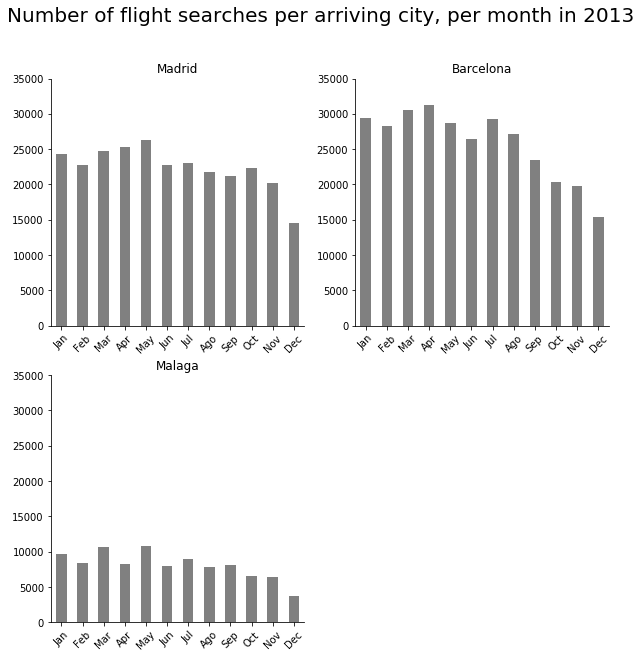

In [19]:
airports = {"MAD":"Madrid","BCN":"Barcelona","AGP":"Malaga"}
months = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Ago","Sep","Oct","Nov","Dec"]

#Create figure
fig = plt.figure(figsize=(10, 10))
fig.suptitle('Number of flight searches per arriving city, per month in 2013', fontsize=20)

#Aggregate and plot
for i,air in enumerate(airports):
    ax = fig.add_subplot(2,2,i+1)
    to_plot = searches_esp[searches_esp["Destination"]==air].resample("M", on="Date").count()
    to_plot["Date"].plot(kind="bar",ax=ax, title=airports[air], rot=45, color="grey", legend=None)
    ax.set_xticklabels(months)
    ax.xaxis.set_label_text("")
    ax.set_ylim(0,35000)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)